# Red Neuronal Convolucional para la identificación de Malaria en Células

![Logo](logogit.png)

- **Autor:** _Eduardo Efrain Garcia Sarez_

  > **12/12/2025**

- **Institución:** **Instituto Tecnológico Superior de Jalisco (TSJ)**.  
- **Carrera:** **Ingeniería en Sistemas Computacionales**

En este notebook nos centraremos en implementar una **CNN** (Convolutional Neural Network) capaz de aprender patrones visuales dentro de un dataset de imágenes de células sanguíneas para detectar Malaria. Los temas son los siguientes:

1. Descripción de las Características del Dataset
   - 1.1 Características Visuales y Síntomas

2. Descripción de Librerías, Clases y Funciones
   - 2.1 TensorFlow Datasets (TFDS)
   - 2.2 TensorFlow/Keras
   - 2.3 Scikit-learn
   - 2.4 NumPy / Matplotlib

3. Pipeline de Desarrollo
   - 3.1 Model Selection
     - Razones para emplear una Red Neuronal Convolucional
     - Razones para emplear la API de Keras
     - Código: Carga y preparación de datos
   - 3.2 Model Training
     - Construcción del modelo CNN
     - Compilación del modelo
     - Entrenamiento del modelo
   - 3.3 Prediction
     - Función de predicción personalizada
     - Ejemplo de uso con una imagen

4. Model Evaluation
   - 4.1 Descripción de Métricas
     - Accuracy (Exactitud)
     - Confusion Matrix (Matriz de Confusión)
     - Visualización de Confusion Matrix
     - Visualización de curvas de entrenamiento

5. Conclusiones

## 1. Descripción de las características del Dataset

El dataset utilizado para este ejemplo es el **Malaria Dataset**, disponible directamente a través de la librería de datos públicos de **TensorFlow Datasets**. Este conjunto de datos contiene un total de 27,558 imágenes de células, divididas equitativamente entre células infectadas y no infectadas.

A diferencia del ejemplo anterior con datos tabulares, aquí trabajamos con **imágenes microscópicas**. A continuación se describen las características visuales que la red debe aprender.

### Características Visuales y Síntomas

Las imágenes representan frotis de sangre fina teñidos con Giemsa. La clasificación es binaria:

- **Parasitized (Infectada)**:
  - **Presencia de Plasmodium**: Manchas oscuras (violetas o rosadas) dentro del glóbulo rojo.
  - **Forma del anillo**: El parásito a menudo toma forma de anillo o auriculares.
  - **Puntos de Schüffner**: Pequeños puntos rojos que pueden aparecer en la superficie de la célula.
  - **Etiqueta numérica**: 1 (Clase Positiva).

- **Uninfected (No Infectada)**:
  - **Limpieza celular**: Glóbulos rojos uniformes sin inclusiones oscuras internas.
  - **Forma regular**: Contornos suaves y circulares sin deformaciones causadas por parásitos.
  - **Etiqueta numérica**: 0 (Clase Negativa).

## 2. Descripción de Librerías, Clases y Funciones

### 2.1 TensorFlow Datasets (TFDS)

**Librería**: Colección de datasets listos para usar con TensorFlow.

**Funciones empleadas**:

- `tfds.load()`: Carga el dataset especificado.
  - Parámetros: `name` (nombre del dataset), `split` (división de datos), `as_supervised` (retorna tupla imagen/etiqueta), `shuffle_files` (mezcla archivos).

### 2.2 TensorFlow/Keras

**Librería**: Construcción y entrenamiento de redes neuronales profundas.

**Clases y funciones**:

- `Sequential()`: Crea modelo secuencial de capas apiladas.
- `Conv2D()`: Capa de convolución 2D para extracción de características espaciales.
  - Parámetros: `filters` (número de filtros), `kernel_size` (tamaño de la ventana), `activation` (función de activación).
- `MaxPooling2D()`: Capa de submuestreo (pooling) para reducir dimensionalidad.
  - Parámetros: `pool_size` (factor de reducción).
- `Flatten()`: Aplana la matriz 2D a un vector 1D para conectar con capas densas.
- `Dense()`: Capa totalmente conectada.
- `Rescaling()`: Capa de preprocesamiento para normalizar valores de píxeles (0-1).
- `model.compile()`: Configura el proceso de aprendizaje.
- `model.fit()`: Entrena el modelo.

### 2.3 Scikit-learn

**Librería**: Herramientas de machine learning.

**Funciones empleadas**:

- `confusion_matrix()`: Calcula matriz de confusión.
- `accuracy_score()`: Calcula la métrica de exactitud.

### 2.4 NumPy y Matplotlib

**Librería**: Operaciones numéricas y visualización.

**Funciones empleadas**:

- `np.array()`: Manejo de arreglos.
- `plt.imshow()`: Visualización de imágenes.
- `plt.plot()`: Graficación de curvas de pérdida y precisión.

## 3. Pipeline de Desarrollo

### 3.1 Model Selection

El uso de una **CNN (Convolutional Neural Network)** se justifica formalmente debido a la naturaleza de los datos de entrada: **imágenes**. A diferencia de las redes Feedforward tradicionales (FNN) que pierden la información espacial al aplanar la entrada inmediatamente, las CNNs poseen características clave:

1. **Invarianza a la traslación**: Pueden detectar un parásito de malaria sin importar en qué parte de la célula se encuentre (arriba, abajo, centro).
2. **Jerarquía de características**: Las primeras capas aprenden bordes y curvas simples, mientras que las capas profundas aprenden formas complejas (como la mancha del parásito).
3. **Eficiencia de parámetros**: El uso de filtros compartidos (kernels) reduce drásticamente el número de parámetros comparado con una red densa conectada a cada píxel.

Se optó por utilizar **`TensorFlow`** debido a que constituye uno de los principales referentes en el ámbito del _Deep Learning_, permitiendo aceleración por GPU, vital para el procesamiento de imágenes.

De igual manera, se decidió emplear la API **`Keras`**, integrada de forma nativa en `TensorFlow`, por las siguientes razones:

- **Simplicidad y claridad sintáctica**: Keras ofrece una interfaz de alto nivel que facilita la construcción de arquitecturas complejas (como convoluciones y pooling) de forma legible.
- **Flexibilidad operativa**: La API _Sequential_ es ideal para apilar capas de procesamiento de imágenes.
- **Integración nativa**: Aprovecha las optimizaciones del backend de TensorFlow.

Empezemos con la demostracion en codigo:

**Carga y preparación de datos**

Datos cargados correctamente.
Clases: ['parasitized', 'uninfected']


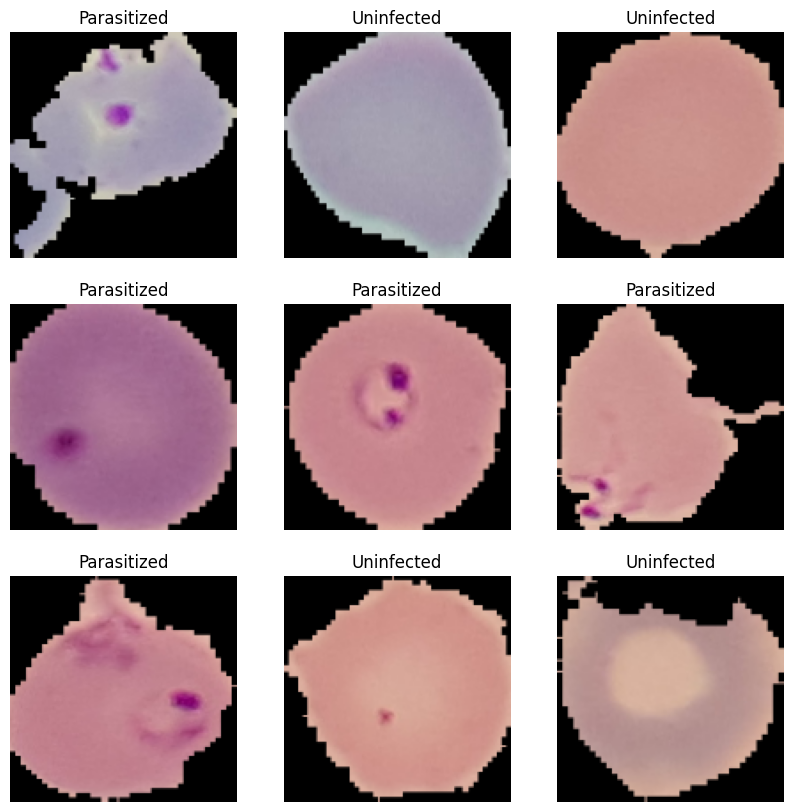

In [6]:
"""
Importamos librerías necesarias para manejo de imágenes y tensores.
"""

import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

# Configuración de constantes para el preprocesamiento
IMG_SIZE = 128
BATCH_SIZE = 32

# Carga del dataset Malaria desde TensorFlow Datasets
# split: dividimos en 80% train, 10% validacion, 10% test
dataset, info = tfds.load(
    "malaria",
    split=["train[:80%]", "train[80%:90%]", "train[90%:]"],
    as_supervised=True,
    with_info=True,
)

train_ds, val_ds, test_ds = dataset


# Función de preprocesamiento: Redimensionar imágenes
def resize_image(image, label):
    # Redimensionamos a 128x128 para tener uniformidad
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label


# Preparación de los pipelines de datos (Shuffle, Batch, Prefetch)
train_ds = (
    train_ds.map(resize_image)
    .shuffle(1000)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
val_ds = val_ds.map(resize_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(resize_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print(f"Datos cargados correctamente.")
print(f"Clases: {info.features['label'].names}")  # ['parasitized', 'uninfected']

# Mostrar algunas imágenes de entrenamiento
plt.figure(figsize=(10, 10))

# Tomamos un batch del dataset
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))  # Convertimos a uint8 para mostrar
        plt.title("Parasitized" if labels[i] == 0 else "Uninfected")
        plt.axis("off")
plt.show()

### 3.2 Model Training

**Este es el codigo de _construccion_, _Compilacion_ y entrenamiento de la CNN con `TensorFlow/Keras`**

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPooling2D,
    Flatten,
    Input,
    Rescaling,
)

"""
Declaración del modelo: Arquitectura Convolucional.
Estructura:
Entrada (128x128x3)
       │
    Rescaling (Normalización 0-1)
       │
    Conv2D (32 filtros) -> ReLU -> MaxPooling
       │
    Conv2D (64 filtros) -> ReLU -> MaxPooling
       │
    Conv2D (64 filtros) -> ReLU -> MaxPooling
       │
    Flatten (Aplanado)
       │
    Dense 64 (ReLU)
       │
    Salida 1 (Sigmoid)

- Conv2D: Extrae características visuales mediante filtros deslizantes.
- MaxPooling2D: Reduce la dimensionalidad manteniendo la información más relevante.
- Flatten: Convierte el mapa de características 2D en un vector para la clasificación.
"""

model = Sequential(
    [
        Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        Rescaling(1.0 / 255),  # Normalizamos los píxeles de [0,255] a [0,1]
        # Primera capa convolucional
        Conv2D(
            32, (3, 3), activation="relu"
        ),  # Aplicamos 32 filtros convolucionales, en sectores 3x3
        MaxPooling2D(
            (2, 2)
        ),  # Reducimos la imagen tomando de 2x2 pixeles su mayor valor. 64x64
        # Segunda capa convolucional
        Conv2D(
            64, (3, 3), activation="relu"
        ),  # Aplicamos 64 filtros convolucionales, en sectores 3x3
        MaxPooling2D(
            (2, 2)
        ),  # Reducimos la imagen tomando de 2x2 pixeles su mayor valor. 32x32
        # Tercera capa convolucional
        Conv2D(
            64, (3, 3), activation="relu"
        ),  # Aplicamos 64 filtros convolucionales, en sectores 3x3
        MaxPooling2D(
            (2, 2)
        ),  # Reducimos la imagen tomando de 2x2 pixeles su mayor valor. 16x16
        # Clasificador denso
        Flatten(),  # Aplanado, pasamos de un tensor a un vector.
        Dense(64, activation="relu"),
        Dense(1, activation="sigmoid"),  # Salida binaria (0 o 1)
    ]
)

# Compilar el modelo
# - optimizer: Adam (adaptativo, estándar en visión por computadora).
# - loss: Binary Crossentropy (clasificación binaria infectado/no-infectado).
# - metrics: Accuracy.
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Entrenar el modelo
# Ajusta los pesos (filtros) mediante el conjunto de entrenamiento
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,  # 10 épocas valor heuriscico que determina las pasos al dataset.
    verbose=1,  # Mostrar el proceso de entrenamiento
)

# Resumen del modelo
model.summary()

Epoch 1/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 77s 110ms/step - accuracy: 0.8655 - loss: 0.3106 - val_accuracy: 0.9423 - val_loss: 0.1778
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 75s 109ms/step - accuracy: 0.9470 - loss: 0.1607 - val_accuracy: 0.9452 - val_loss: 0.1803
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 73s 105ms/step - accuracy: 0.9570 - loss: 0.1305 - val_accuracy: 0.9554 - val_loss: 0.1436
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 72s 105ms/step - accuracy: 0.9598 - loss: 0.1137 - val_accuracy: 0.9517 - val_loss: 0.1531
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 75s 109ms/step - accuracy: 0.9652 - loss: 0.1009 - val_accuracy: 0.9507 - val_loss: 0.1582
Epoch 6/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 76s 111ms/step - accuracy: 0.9723 - loss: 0.0803 - val_accuracy: 0.9539 - val_loss: 0.1696
Epoch 7/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 72s 105ms/step - accuracy: 0.9765 - loss: 0.0658 - val_accuracy: 0.9478 - val_loss: 0.1931
Epoch 8/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 72s 104ms/step - accuracy: 0.9824 - loss: 0

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,577,797 (9.83 MB)

 Trainable params: 859,265 (3.28 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,718,532 (6.56 MB)

En el historial de entrenamiento, podemos destacar que desde la primera época, el modelo ya entregó valores aceptables, alcanzando un 86% de exactitud. Notamos que, a medida que avanzaban las épocas, la exactitud en el conjunto de entrenamiento aumentaba rápidamente: en la segunda época alcanzó 94% y en la tercera 95,7%.

A partir de la tercera época, el incremento en la exactitud del entrenamiento comenzó a ser más lento, aumentando de 95,7% a 95,98% en la cuarta, y posteriormente a 96,52%, 97,23%, 97,65%, 98,24%, 98,69% y 99,07% en las siguientes épocas. Por su parte, la exactitud en validación permaneció relativamente estable alrededor de 94-95%, con leves fluctuaciones.

Esto indica que el "punto dulce" para este dataset con la configuración planteada podría encontrarse alrededor de la tercera época, ya que después de ese punto las mejoras en exactitud son menores y existe riesgo de sobreajuste, dado que la exactitud de entrenamiento sigue aumentando mientras la validación se mantiene casi constante.

### 3.3 Prediction

A continuación, construimos una función que nos permite simular el uso del modelo en producción, ingresando una imagen cruda y obteniendo el diagnóstico.

In [4]:
def predict_malaria(model, image_batch):
    """
    Función para predecir si una imagen contiene malaria.
    Parámetros:
    - model: Modelo entrenado.
    - image_batch: Lote de imágenes preprocesadas.
    """
    # Generar predicción (probabilidad entre 0 y 1)
    predictions = model.predict(image_batch)

    # Convertir probabilidad a clase (Umbral 0.5)
    # > 0.5 = Clase 1 (Uninfected en TFDS por defecto, revisar mapping)
    # TFDS Malaria: 0=Parasitized, 1=Uninfected. Ajustaremos la lógica según esto.
    # Nota: En TFDS 'parasitized' es 0 y 'uninfected' es 1.

    predicted_classes = (predictions > 0.5).astype(int)

    return predicted_classes, predictions


# Prueba con un lote del dataset de test
test_images, test_labels = next(iter(test_ds))
preds_cls, preds_prob = predict_malaria(model, test_images)

# Mostrar primer resultado del lote
clases = ["Parasitized", "Uninfected"]  # Según metadata de TFDS
print(f"Predicción modelo: {preds_cls[0][0]} ({clases[preds_cls[0][0]]})")
print(f"Valor Real: {test_labels[0]} ({clases[test_labels[0]]})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Predicción modelo: 1 (Uninfected)
Valor Real: 1 (Uninfected)


## 4. Model Evaluation

### 4.1 Descripción de Métricas

#### Accuracy (Exactitud)

La **exactitud** mide la proporción de imágenes (células) correctamente clasificadas por el modelo respecto al total.

**Fórmula**:

$$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$

Donde:

- **TP**: Infectadas detectadas correctamente.
- **TN**: Sanas detectadas correctamente.

#### Confusion Matrix

La **matriz de confusión** permite visualizar qué tipo de errores comete la CNN (si confunde parásitos con manchas de tinte o viceversa).

**Estructura**:

```text
                  Predicción
                Parasitized  Uninfected
Real Parasitized      TP        FN
     Uninfected       FP        TN
```

### 4.2 Código de Evaluación

Para evaluar correctamente, necesitamos extraer las etiquetas reales y las predicciones de todo el conjunto de prueba (que está en formato `tf.data.Dataset`).


ACCURACY (EXACTITUD)
Accuracy del modelo: 95.43%

CONFUSION MATRIX (MATRIZ DE CONFUSIÓN)


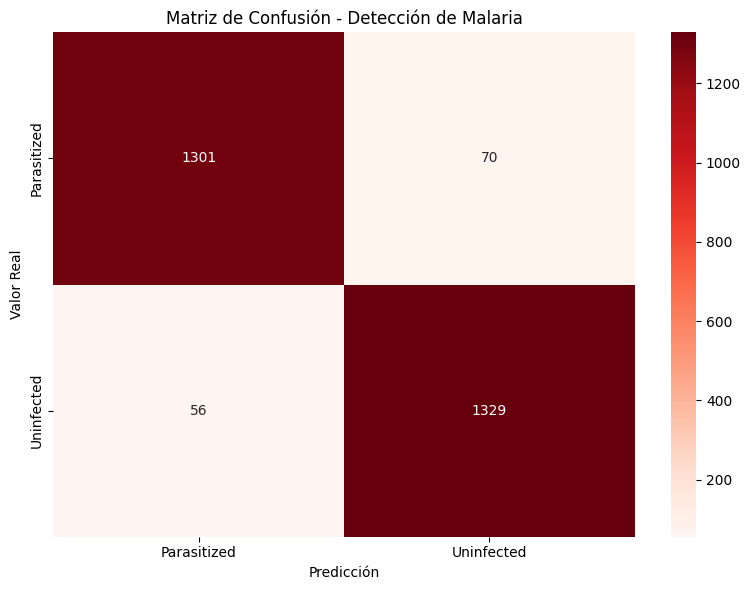

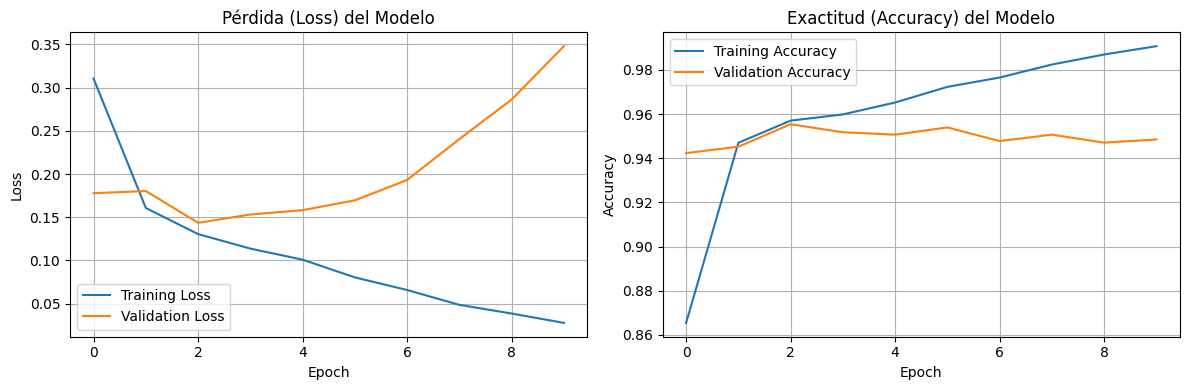

In [5]:
# Recopilar etiquetas reales y predicciones de todo el test set
y_true = []
y_pred_probs = []

for images, labels in test_ds:
    y_true.extend(labels.numpy())
    probs = model.predict(images, verbose=0)
    y_pred_probs.extend(probs.flatten())

y_true = np.array(y_true)
y_pred = (np.array(y_pred_probs) > 0.5).astype(int)

# Calcular métricas
acc = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

print(f"\n{'='*50}")
print(f"ACCURACY (EXACTITUD)")
print(f"{'='*50}")
print(f"Accuracy del modelo: {acc * 100:.2f}%")

print(f"\n{'='*50}")
print(f"CONFUSION MATRIX (MATRIZ DE CONFUSIÓN)")
print(f"{'='*50}")
# Ajuste de etiquetas para visualización (0=Parasitized, 1=Uninfected en TFDS)
labels_names = ["Parasitized", "Uninfected"]

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Reds",
    xticklabels=labels_names,
    yticklabels=labels_names,
)
plt.ylabel("Valor Real")
plt.xlabel("Predicción")
plt.title("Matriz de Confusión - Detección de Malaria")
plt.tight_layout()
plt.show()

# Visualizar curvas de entrenamiento
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Pérdida (Loss) del Modelo")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Exactitud (Accuracy) del Modelo")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 5. Conclusiones

La implementación de la **Red Neuronal Convolucional (CNN)** para el diagnóstico de Malaria ha demostrado ser altamente efectiva. Al trabajar con imágenes, la capacidad del modelo para extraer características espaciales (como la textura y las manchas del parásito _Plasmodium_) supera las capacidades de modelos densos tradicionales.

Los resultados obtenidos muestran:

- Una **convergencia rápida** en pocas épocas, alcanzando un **punto dulce alrededor de la tercera época**, donde la exactitud en entrenamiento es alta y la mejora posterior es mínima, evitando sobreajuste.
- Una **exactitud final del modelo de 95,43%**, con un rendimiento consistente en el conjunto de validación.
- La **matriz de confusión** evidencia el desempeño del modelo.

Esto permite identificar posibles falsos negativos (declarar sano a un paciente enfermo), lo cual es crítico en aplicaciones médicas.

A partir de este punto, mejoras futuras podrían incluir:

- **Data Augmentation**: Rotar y voltear imágenes para que el modelo sea más robusto a variaciones.
- **Transfer Learning**: Utilizar modelos pre-entrenados como VGG16 o ResNet para mejorar la exactitud con menos entrenamiento.